<h1><center><font color=purple>Plotting a choropleth map of Zurich's city districts</font></center></h1>
<h4><center><font color=purple>(2) using Geopandas and Folium</font></center></h4>

***

<strong>Key objectives:<br></strong>Create a region map (choropleth map) of Zurich's city districts using <b> Geopandas and Folium</b>. Information for districts should be shown by coloring each disctrict according to a corresponding value. The color palette should be shown in a legend. Ideally the map should be interactive.

<strong>Dataset:<br></strong> (1) <i>'Generalisierte Gemeindegrenzen (OGD) (kantonaler Datensatz)'</i> from https://www.stadt-zuerich.ch/geodaten/

<h3><left><font color=purple>Contents:</font></left></h3>

[1. Import shapefiles](#section-1-title)

[2. Plot all districts of Zürich](#section-2-title)

[3. Highlight some of Zürich's districts](#section-3-title)

[4. Color districts according to some data](#section-4-title)

[5. Plot districts in interactive map](#section-5-title)

[6. Discussion](#section-6-title)
***

In [2]:
# imports
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
import folium
%matplotlib inline

<a id='section-1-title'></a>
[<h3><font color=purple>1. Import shapefiles</font></h3>](#section-1-title)

In [3]:
# load shapefile into Geopandas
shp_path = 'data/raw/stadtkreise/UP_GEMEINDEN_STADTQUARTIERE_F.shp'
gdf = gpd.read_file(shp_path)
gdf.head(3)

,BFS,GEMEINDENA,BEZIRKSNAM,QUARTIERNA,QUARTIERNU,ART_TEXT,ART_CODE,SHAPE_AREA,SHAPE_LEN,geometry
0,12,Rifferswil,Affoltern,None,NaN,Gemeinde,1,6.509792e+06,15891.253368,"POLYGON ((2680429.631 1235062.534, 2680430.828..."
1,261,Zürich,Zürich,Friesenberg,33.0,Gemeinde,1,5.297366e+06,13298.957216,"POLYGON ((2680607.003 1247034.307, 2680607.325..."
2,248,Uitikon,Dietikon,None,NaN,Gemeinde,1,4.378205e+06,14116.044778,"POLYGON ((2676260.659 1248138.195, 2676308.776..."


<a id="section-2-title_"></a>
[<h3><font color=purple>2. Plot all districts of Zürich</font></h3>](#section-2-title_)

/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


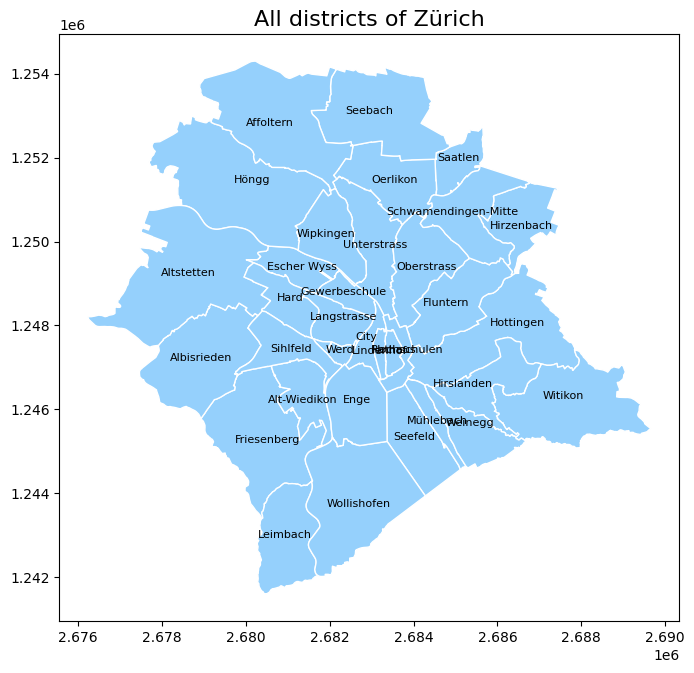

In [61]:
# plot all districts
gdf_ = gdf[gdf.GEMEINDENA == 'Zürich']
gdf_.loc[:,'district_center'] = gdf_['geometry'].apply(lambda x: x.representative_point().coords[0])
ax = gdf_.plot(edgecolor='white',facecolor='xkcd:light blue',figsize=(8,8))
for idx, row in gdf_.iterrows():
    plt.annotate(text=row['QUARTIERNA'],xy=row['district_center'],horizontalalignment='center',fontsize=8)
ax.set_title('All districts of Zürich',size=16);

<a id="section-3-title"></a>
[<h3><font color=purple>3. Highlight some of Zürich's districts</font></h3>](#section-3-title)

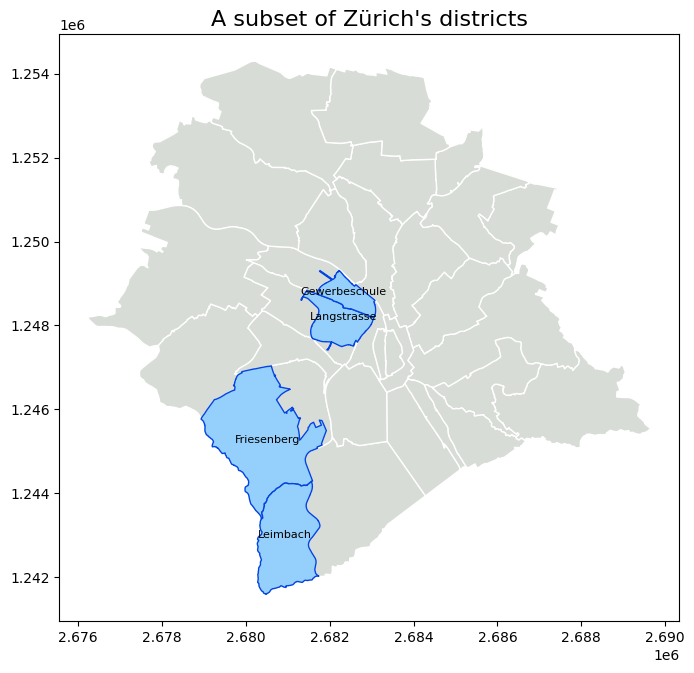

In [65]:
# plot a subset of the districts
district_list = ['Langstrasse','Gewerbeschule','Leimbach','Friesenberg']

gdf_subset = gdf_[gdf_.QUARTIERNA.isin(district_list)]
gdf_subset.loc[:,'district_center'] = gdf_['geometry'].apply(lambda x: x.representative_point().coords[0])

ax = gdf_.plot(edgecolor='white',linewidth=1,facecolor='xkcd:light grey',figsize=(8,8))
gdf_subset.plot(ax=ax,edgecolor='xkcd:blue',facecolor='xkcd:light blue',linewidth=1)
for idx, row in gdf_subset.iterrows():
    plt.annotate(text=row['QUARTIERNA'],xy=row['district_center'],horizontalalignment='center',fontsize=8)
ax.set_title("A subset of Zürich's districts",size=16);

<a id="section-4-title"></a>
[<h3><font color=purple>4. Color districts according to some data</font></h3>](#section-4-title)

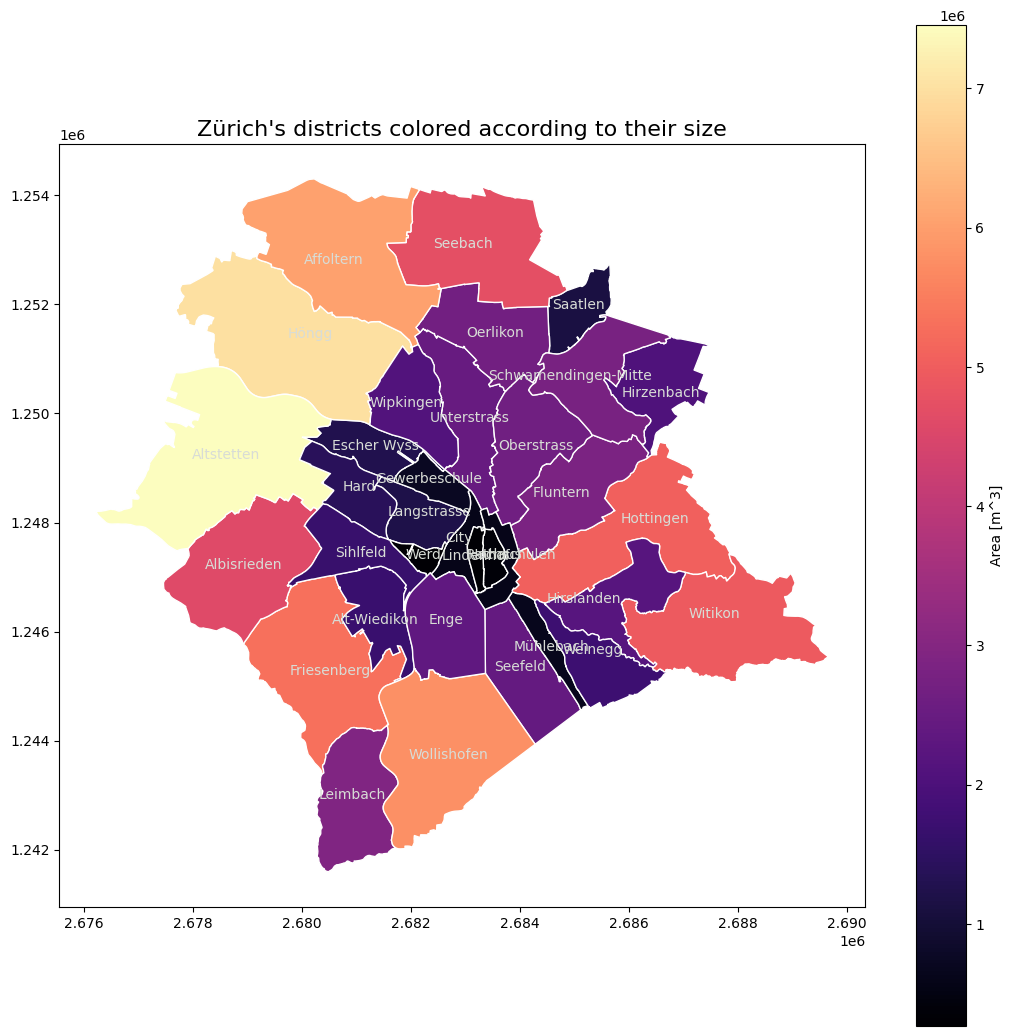

In [71]:
# color districts using 'SHAPE_AREA' column
gdf_.loc[:,'district_center'] = gdf_['geometry'].apply(lambda x: x.representative_point().coords[0])

ax = gdf_.plot(column='SHAPE_AREA',edgecolor='xkcd:white',linewidth=1,legend=True,cmap='magma',legend_kwds={"label": "Area [m^3]"},figsize=(13,13));
for idx, row in gdf_.iterrows():
    plt.annotate(text=row['QUARTIERNA'],xy=row['district_center'],horizontalalignment='center',fontsize=10,color="xkcd:light grey")
ax.set_title("Zürich's districts colored according to their size",size=16);

<a id="section-5-title"></a>
[<h3><font color=purple>5. Plot districts in interactive map</font></h3>](#section-5-title)

In [52]:
# plot districts in interactive map
transformer = Transformer.from_crs("EPSG:2056", 'epsg:4326')
gdf_.loc[:,["district_center_wgs84"]] = gdf_['district_center'].map(lambda p: transformer.transform(p[0],p[1]))
gdf_.loc[:,'lat'] = gdf_['district_center_wgs84'].map(lambda p: p[0])
gdf_.loc[:,'lon'] = gdf_['district_center_wgs84'].map(lambda p: p[1])

m = folium.Map(location=[47.38,8.55], zoom_start=12)
for i, row in gdf_.iterrows():
  folium.map.Marker(
      [row['lat'],row['lon']], #[row['lat'],row['lon']]
      icon=folium.features.DivIcon(
          icon_size=(100,24),
          icon_anchor=(50,12),
          html=f'<div align="center" style="font-size: 6pt; font-weight: bold">{row["QUARTIERNA"]}</div>', # color:white;
      )
  ).add_to(m);

gdf_.explore(
    m=m,
    column="SHAPE_AREA",  # make choropleth based on "SHAPE_AREA" column
    tooltip="SHAPE_AREA",  # show "SHAPE_AREA" value in tooltip (on hover)
    popup=False,  # don't show popup (on click)
    cmap="magma",  # use "magma" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
)

<a id="section-6-title"></a>
[<h3><font color=purple>6. Discussion</font></h3>](#section-6-title)

(1) When handling shapefiles Geopandas makes our life  quite easy: shapefiles can directly be imported, coordinates can be transformed and it has many plotting capabilities. 

(2) By using folium, interactive maps as well as webbased maps can easily be generated. However, text annotations on folium maps aren't natively supported, hence the use of html in the marker function. A problem that remains, is that when zooming into city districts the text does automatically scale which is not always desired.